In [109]:
import tensorflow as tf
from tensorflow import keras
import os
import copy
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import librosa
from numpy import random

import librosa.display
import matplotlib.pyplot as plt

training_groundtruth = pd.read_csv('/kaggle/input/training-groundtruth/training-groundtruth-new.csv')
AUDIO_FILES_DIR = '/kaggle/input/mp3files-nodoctor/rmDoc-audio/'
AUDIO_FILES = sorted([x for x in os.listdir(AUDIO_FILES_DIR) if x[-4:]=='.wav'])

In [110]:
def noise(data):
    noise_amp = 0.03*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()
# Code copied and edited from https://www.kaggle.com/code/davids1992/specaugment-quick-implementation
def spec_augment(original_melspec,
                 freq_masking_max_percentage = 0.05, 
                 time_masking_max_percentage = 0.05):

    augmented_melspec = original_melspec.copy()
    all_frames_num, all_freqs_num = augmented_melspec.shape

    # Frequency masking
    freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
    num_freqs_to_mask = int(freq_percentage * all_freqs_num)
    f0 = int(np.random.uniform(low = 0.0, high = (all_freqs_num - num_freqs_to_mask)))
    
    augmented_melspec[:, f0:(f0 + num_freqs_to_mask)] = 0

    # Time masking
    time_percentage = random.uniform(0.0, time_masking_max_percentage)
    num_frames_to_mask = int(time_percentage * all_frames_num)
    t0 = int(np.random.uniform(low = 0.0, high = (all_frames_num - num_frames_to_mask)))
    
    augmented_melspec[t0:(t0 + num_frames_to_mask), :] = 0
    
    return augmented_melspec

In [111]:
# https://www.kaggle.com/code/abduallahhussien/speech-emotion-recognition-93-accuracy
def extract_features(data, sr, SpecAugment = False):
    
    result = np.array([])
    
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    if SpecAugment:
        mfccs = spec_augment(mfccs)
     
    return mfccs

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=70, offset=0.5, sr=None)
    avg_Size = sample_rate*70
    data = np.pad(data, (0,max(0,avg_Size-len(data))), 'constant')
    
    #without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(np.expand_dims(res1, axis=0))
    
    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, np.expand_dims(res2, axis=0))) # stacking vertically
    
    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data, sample_rate)
    result = np.vstack((result, np.expand_dims(res5, axis=0))) 
                     
    #SpecAugment
    res8 = extract_features(data, sample_rate, True)
    result = np.vstack((result, np.expand_dims(res8, axis=0)))
                     
    return result

In [112]:
# trillsson_features = np.load('/kaggle/input/70s-trillsson3-dementia-adress-m-train/embeddings (1).npy', allow_pickle=True)
# print(trillsson_features.shape)
# trillsson_features = tf.convert_to_tensor(trillsson_features)
# print(trillsson_features)

In [113]:
# get_features(AUDIO_FILES_DIR + AUDIO_FILES[0]).shape

In [114]:
data_train = []
data_test = []
x_train = []
x_test = []
y_train = []
y_test = []
length = 0
cou = 0
for index, row in training_groundtruth.iterrows():
    row['index'] = index
    length+=1
    if row['type'] == "train":
        data_train.append(row)
    else:
        data_test.append(row)

for rows_of_type in [data_train, data_test]:
    for row in rows_of_type:
        temp = []
#         temp += [row['age']/100]
#         temp += [1 if row['gender'] == 'female' else 0]
#         temp += [row['educ']/30 if not np.isnan(row['educ']) else 0]
        temp = np.array(temp)
#         temp = np.concatenate((temp, trillsson_features[row['index']][0]))
        cou+=1
        print(f'Status {int(cou/length*100)}%', end='\r')
        if row['type'] == "train":
            mfccs_feature = get_features(AUDIO_FILES_DIR + AUDIO_FILES[row['index']])
            for f in mfccs_feature:
                x_train.append(f)
                y_train.append(1 if row['dx'] == 'ProbableAD' else 0)
        else:
            f = get_features(AUDIO_FILES_DIR + AUDIO_FILES[row['index']])[0]
            x_test.append(f)
            y_test.append(1 if row['dx'] == 'ProbableAD' else 0)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [119]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((788, 13, 2188, 1), (40, 13, 2188, 1), (788,), (40,))

In [116]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((788, 13, 2188, 1), (40, 13, 2188, 1), (788,), (40,))

In [164]:
# create sequential model with 4 CNN layers then flatten then dense then output
# from keras.layers import BatchNormalization, Dropout
from keras import regularizers
model = keras.Sequential()
model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(13, 2188, 1), kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(0.05)))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(Dropout(0.4))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

rlrp = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 30,
                              restore_best_weights = True)

history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp,earlystopping])
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

Epoch 1/100
13/13 [==============================] - 2s 37ms/step - loss: 16.3782 - accuracy: 0.5317 - val_loss: 15.0324 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 2/100
13/13 [==============================] - 0s 19ms/step - loss: 14.2199 - accuracy: 0.6320 - val_loss: 13.4021 - val_accuracy: 0.5750 - lr: 0.0100
Epoch 3/100
13/13 [==============================] - 0s 18ms/step - loss: 12.7100 - accuracy: 0.7183 - val_loss: 12.1819 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 4/100
13/13 [==============================] - 0s 21ms/step - loss: 11.3006 - accuracy: 0.7690 - val_loss: 10.7794 - val_accuracy: 0.7000 - lr: 0.0100
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 9.9511 - accuracy: 0.8655 - val_loss: 9.6918 - val_accuracy: 0.5250 - lr: 0.0100
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 8.7264 - accuracy: 0.9124 - val_loss: 8.4636 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 7/100
12/13 [==========================>...] - ETA: 0s -

2/2 [==============================] - 0s 8ms/step - loss: 4.6380 - accuracy: 0.8500
Accuracy of our model on test data :  85.0 %


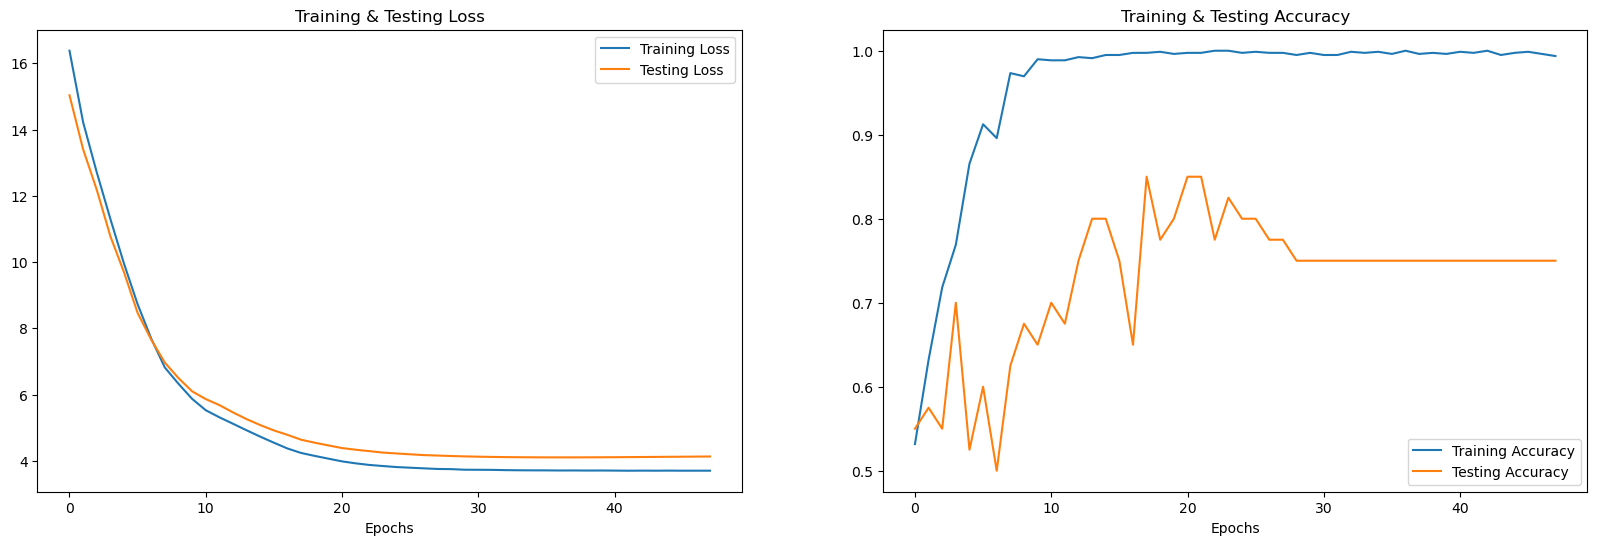

In [166]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
epochs = [i for i in range(len(train_acc))]

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [167]:
print(tf.math.confusion_matrix(y_test,model.predict(x_test).round(),2))
# [positive control negative AD
#  negative control positive AD]

2/2 [==============================] - 0s 5ms/step
tf.Tensor(
[[15  5]
 [ 1 19]], shape=(2, 2), dtype=int32)


In [168]:
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 8ms/step - loss: 4.6380 - accuracy: 0.8500


[4.637995719909668, 0.8500000238418579]

In [171]:
model.save('/kaggle/working/model85.keras')